# Classification of three arrythmia types 

AI in Healthcare project

## Load dependencies and define arrythmia types

Define the arrythmia types I want to have a closer look at.


In [63]:
import pandas as pd
import os
import numpy as np
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal



In [64]:
class ArrhythmiaTypes(Enum):
    SB = "SB"
    AFIB = "AFIB"
    SR = "SR"

## Load and prepare the data

In the following step the diagnostic data and the ecg data is combined into a data frame.

In [65]:
diagnostics_file = 'Diagnostics.xlsx'
diagnostics_data = pd.read_excel(diagnostics_file)

# Filter the diagnostics data based on Arrhythmia types in the enum
allowed_rhythms = [arrhythmia.value for arrhythmia in ArrhythmiaTypes]
filtered_diagnostics_data = diagnostics_data[diagnostics_data['Rhythm'].isin(allowed_rhythms)]

combined_data_list = []

ecg_files = os.listdir('ECGData')

# REMOVE THIS AND CORRESPONSING CODE Process the first n files
files_number = 200

for i, file_name in enumerate(ecg_files):
    #REMOVE only for dev: only use the first couple of files
    if i >= files_number:
        break

    ecg_file_path = os.path.join('ECGData', file_name)

    ecg_data = pd.read_csv(ecg_file_path)
    #ecg_data = ecg_data.iloc[1:].reset_index(drop=True)

    # Find the corresponding row in the filtered diagnostics data
    diagnostics_row = filtered_diagnostics_data[filtered_diagnostics_data['FileName'] == file_name.replace('.csv', '')]

    if not diagnostics_row.empty:
        combined_dict = diagnostics_row.iloc[0].to_dict()

        # Add ECG data to the dictionary
        for col in ecg_data.columns:
            combined_dict[f'ECG_{col}'] = ecg_data[col].tolist()

        combined_data_list.append(combined_dict)

combined_df = pd.DataFrame(combined_data_list)

# Replace empty lists with NaN
combined_df = combined_df.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)

print(combined_df.iloc[0])
#REMOVE print(combined_df.columns)
#print(combined_df.head())


FileName                                  MUSE_20180209_170349_37000
Rhythm                                                            SR
Beat                                                            NONE
PatientAge                                                        66
Gender                                                        FEMALE
VentricularRate                                                   61
AtrialRate                                                        61
QRSDuration                                                       72
QTInterval                                                       388
QTCorrected                                                      390
RAxis                                                             40
TAxis                                                             39
QRSCount                                                          11
QOnset                                                           220
QOffset                           

/var/folders/pb/22cxtyzd653c2q7dxd_fy0_r0000gp/T/ipykernel_702/722337044.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)


## Data exploration

Before I start the exploration I want to have a look at the percentage of each arrythmia type in the unfiltered dataset to choose the most common arrythmia types.

In [66]:
def analyze_arrhythmia_distribution(diagnostics_file_path):
    df = pd.read_excel(diagnostics_file_path)
    
    # Count the occurrences of each arrhythmia type
    arrhythmia_counts = df['Rhythm'].value_counts()
    
    # Calculate percentages
    total_count = len(df)
    arrhythmia_percentages = (arrhythmia_counts / total_count) * 100
    
    distribution_df = pd.DataFrame({
        'Count': arrhythmia_counts,
        'Percentage': arrhythmia_percentages
    })
    
    print("Arrhythmia Distribution:")
    print(distribution_df)

analyze_arrhythmia_distribution('Diagnostics.xlsx')


Arrhythmia Distribution:
        Count  Percentage
Rhythm                   
SB       3889   36.530152
SR       1826   17.151982
AFIB     1780   16.719895
ST       1568   14.728537
SVT       587    5.513808
AF        445    4.179974
SA        399    3.747887
AT        121    1.136577
AVNRT      16    0.150291
AVRT        8    0.075146
SAAWR       7    0.065752


First I want to have a general overview over the data in the filtered dataset: the gender, age and arrythmia type distribution.

In [67]:
# Visualize Gender Distribution
def visualize_gender():
    plt.figure(figsize=(4, 2))
    sns.countplot(x='Gender', data=filtered_diagnostics_data)
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

# Calculate exact numbers
def calc_gender():
    gender_counts = filtered_diagnostics_data['Gender'].value_counts()
    total_counts = combined_df.shape[0]

    print("Number of data sets by gender:")
    print(gender_counts)

In [68]:
# Visualize Age Distribution
def visualize_age():
    plt.figure(figsize=(4, 2))
    sns.histplot(filtered_diagnostics_data['PatientAge'], kde=True, bins=10)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

# Calculate exact numbers
def calc_age_boxplot():
    age = filtered_diagnostics_data['PatientAge']
    min_age = age.min()
    max_age = age.max()
    mean_age = age.mean()
    median_age = age.median()
    std_dev_age = age.std()

    # Create box plot
    plt.figure(figsize=(4, 2))
    ax = sns.boxplot(y=age, color='lightblue')

    plt.axhline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.2f}')
    plt.axhline(median_age, color='green', linestyle='-', label=f'Median: {median_age:.2f}')
    plt.title('Box Plot of Patient Age with Mean and Median')
    plt.ylabel('Age')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print("Age Statistics:")
    print(f"Minimum Age: {min_age}")
    print(f"Maximum Age: {max_age}")
    print(f"Mean Age: {mean_age:.2f}")
    print(f"Median Age: {median_age}")
    print(f"Standard Deviation of Age: {std_dev_age:.2f}")

In [69]:
# Visualize Arrythmia Distribution
def visualize_arrythmia():
    plt.figure(figsize=(4, 2))
    sns.countplot(x='Rhythm', data=filtered_diagnostics_data)
    plt.title('Arrythmia Types Distribution')
    plt.xlabel('Arrythmia Type')
    plt.ylabel('Count')
    plt.show()

In [70]:
# Visualize gender and age
def visualize_gender_age():
    plt.figure(figsize=(4, 2))
    sns.boxplot(x='Gender', y='PatientAge', data=combined_df)
    plt.title('Age Distribution by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Age')
    plt.show()

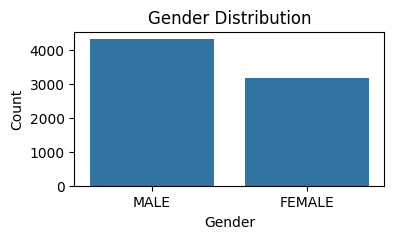

Number of data sets by gender:
Gender
MALE      4324
FEMALE    3171
Name: count, dtype: int64


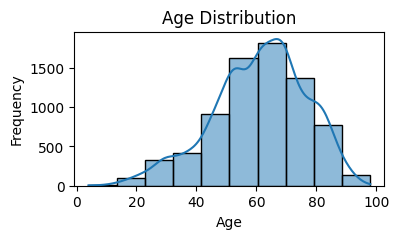

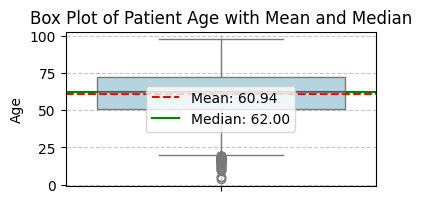

Age Statistics:
Minimum Age: 4
Maximum Age: 98
Mean Age: 60.94
Median Age: 62.0
Standard Deviation of Age: 15.69


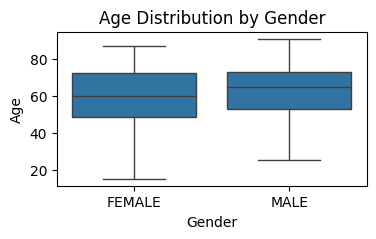

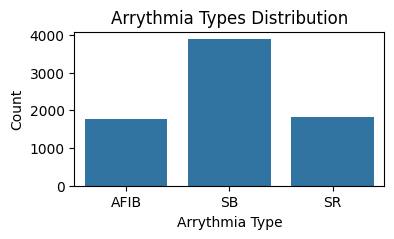

In [71]:
visualize_gender()
calc_gender()
visualize_age()
calc_age_boxplot()
visualize_gender_age()
visualize_arrythmia()

Next I want to compare the ECG leads for the different arrythmia types. The following visualization shows the various arrythmia types and the distribution of thei values and potential outliers:

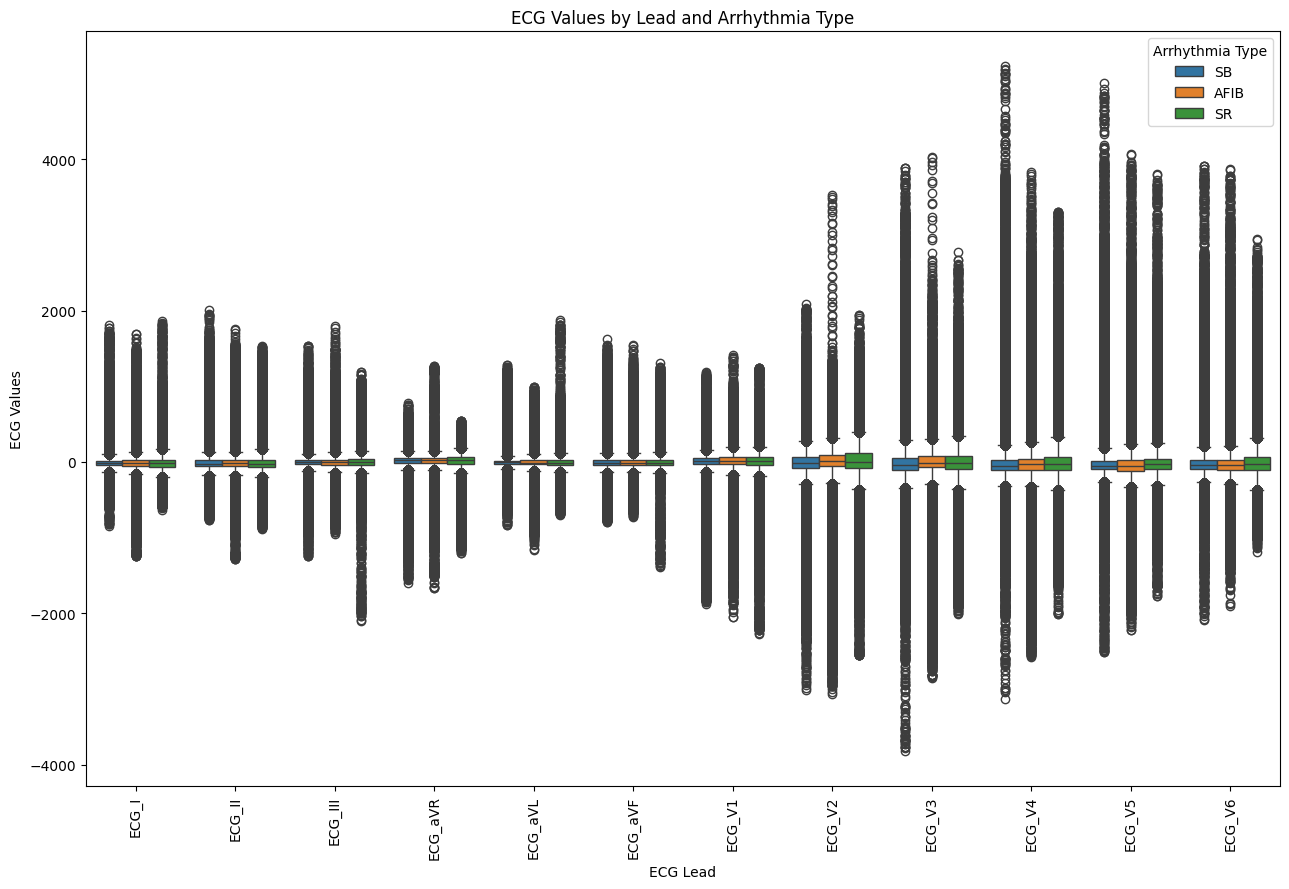

In [72]:
def plot_combined_ecg_boxplots(combined_df):
    # List of ECG columns
    ecg_leads = [col for col in combined_df.columns if col.startswith('ECG_')]
    
    ecg_data_combined = []
    
    for lead in ecg_leads:
        # Flatten the ECG data lists for each arrhythmia type
        for arrhythmia_type in ArrhythmiaTypes:
            data = combined_df[combined_df['Rhythm'] == arrhythmia_type.value][lead]
            if isinstance(data.iloc[0], list):  # Check if data is a list
                data = [item for sublist in data.dropna() for item in sublist]
            else:
                data = data.dropna()
            
            ecg_data_combined.append(pd.DataFrame({
                'ECG_Lead': lead,
                'Arrhythmia': arrhythmia_type.value,
                'ECG_Value': data
            }))
    
    # Combine all data into one DataFrame
    combined_df_ecg = pd.concat(ecg_data_combined)
    
    plt.figure(figsize=(13, 9))
    sns.boxplot(x='ECG_Lead', y='ECG_Value', hue='Arrhythmia', data=combined_df_ecg)
    
    plt.title('ECG Values by Lead and Arrhythmia Type')
    plt.xlabel('ECG Lead')
    plt.ylabel('ECG Values')
    plt.legend(title='Arrhythmia Type')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()

plot_combined_ecg_boxplots(combined_df)

Now I want to have a closer look at each lead/channel:

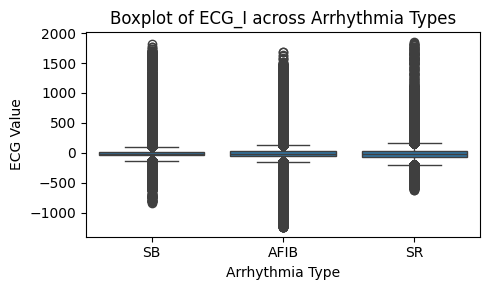

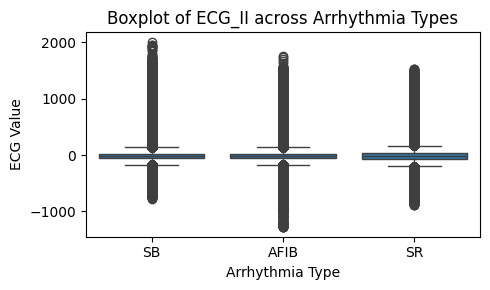

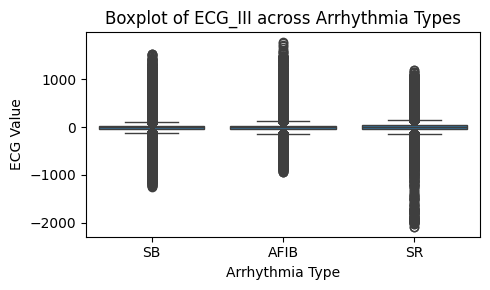

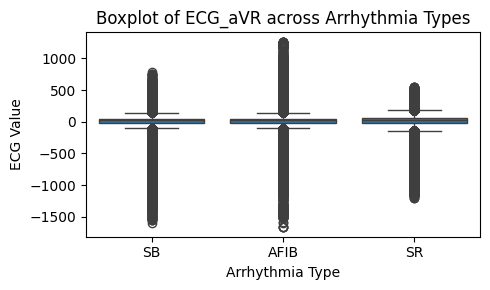

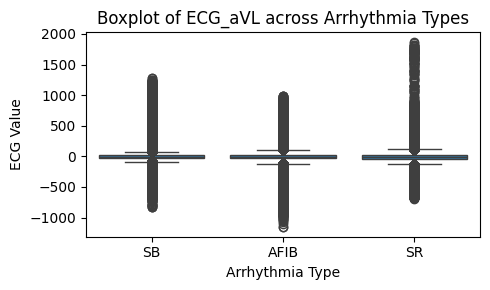

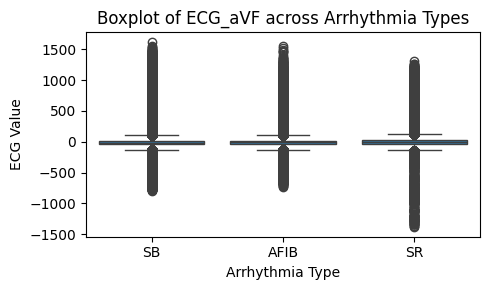

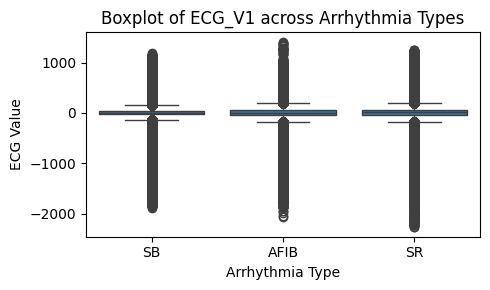

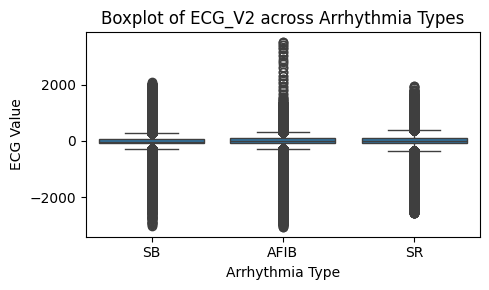

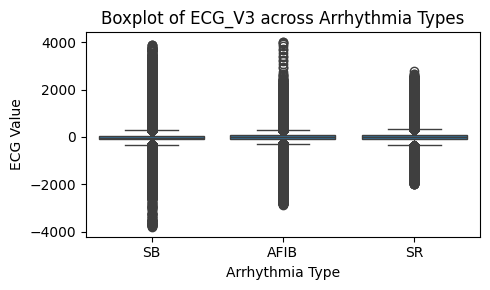

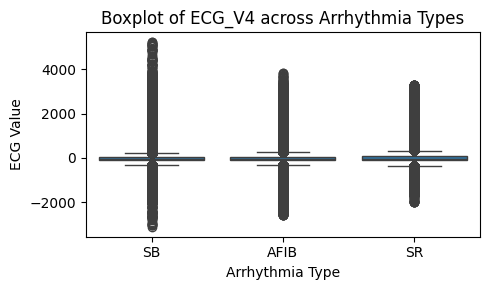

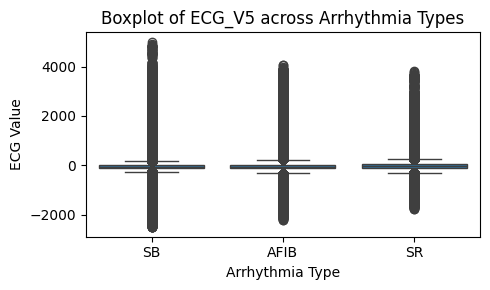

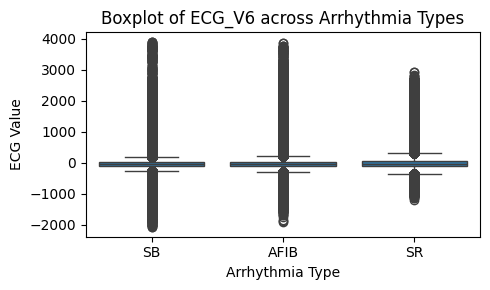

In [73]:
def compare_arrhythmias(combined_df):
    melted_data = []
    
    for arrhythmia_type in ArrhythmiaTypes:
        filtered_df = combined_df[combined_df['Rhythm'] == arrhythmia_type.value]
        
        for col in filtered_df.columns:
            if col.startswith('ECG_'):
                # For each ECG lead, concatenate the data and store it along with the arrhythmia type
                ecg_data = np.concatenate(filtered_df[col].dropna().values)
                for value in ecg_data:
                    melted_data.append({'ECG_Lead': col, 'ECG_Value': value, 'Arrhythmia': arrhythmia_type.value})
    
    # Convert to a DataFrame for visualization
    melted_df = pd.DataFrame(melted_data)
    
    ecg_leads = melted_df['ECG_Lead'].unique()
    
    # Plot the boxplots for each ECG lead
    for lead in ecg_leads:
        plt.figure(figsize=(5, 3))
        
        # Filter data for the current lead
        lead_data = melted_df[melted_df['ECG_Lead'] == lead]
        
        sns.boxplot(x='Arrhythmia', y='ECG_Value', data=lead_data)
        
        plt.title(f'Boxplot of {lead} across Arrhythmia Types')
        plt.ylabel('ECG Value')
        plt.xlabel('Arrhythmia Type')
        
        plt.tight_layout()
        plt.show()

compare_arrhythmias(combined_df)


Next I want to look at the variance of the ECG leads across the different arrythmia types:

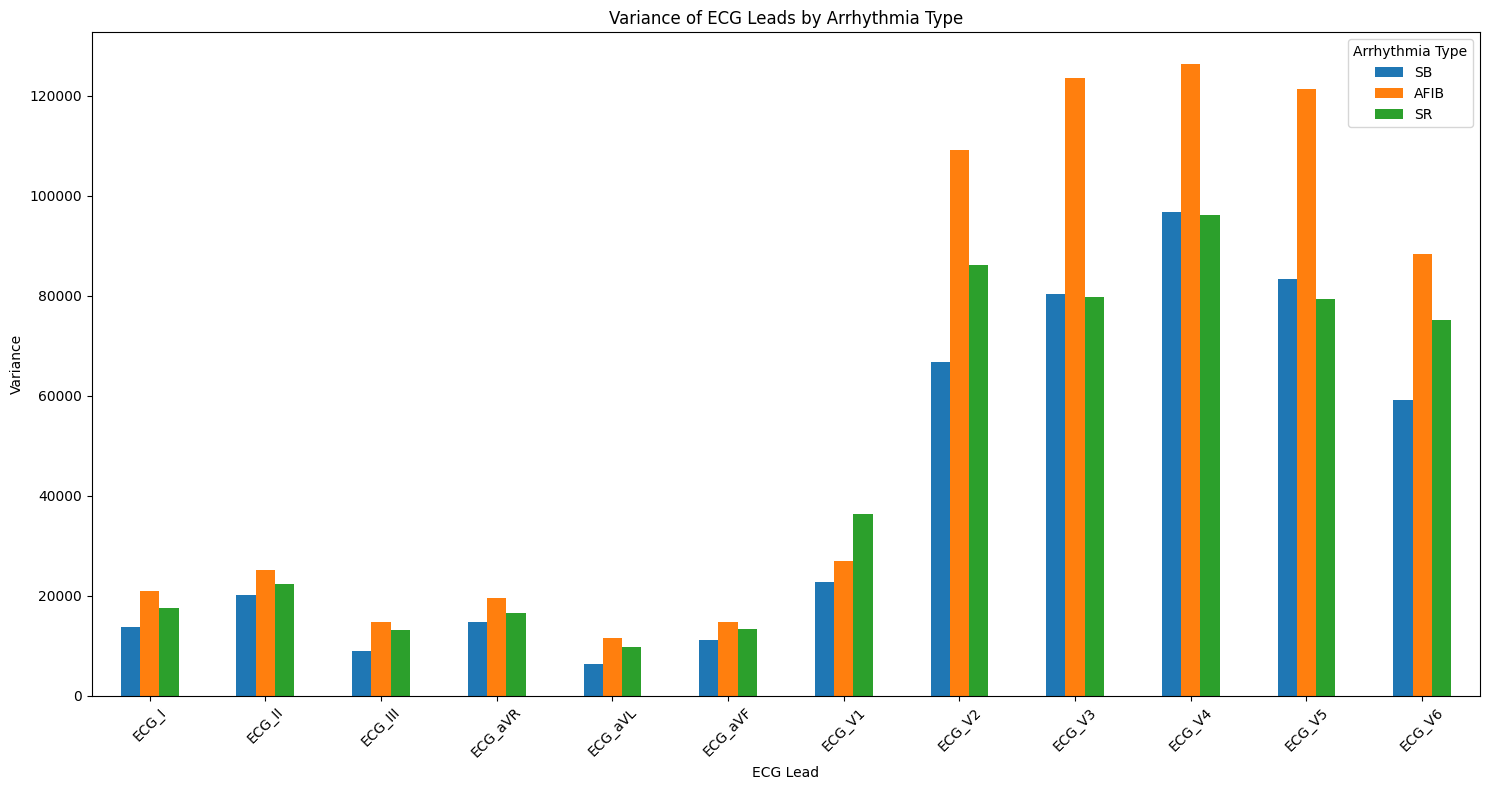

In [74]:
def calculate_variance(df, arrhythmia_type):
    filtered_df = df[df['Rhythm'] == arrhythmia_type.value]
    variances = {}
    for col in filtered_df.columns:
        if col.startswith('ECG_'):
            ecg_data = np.concatenate(filtered_df[col].dropna().values)
            variances[col] = np.var(ecg_data)
    return pd.Series(variances, name=arrhythmia_type.value)

def visualize_variances(combined_df):
    # Calculate variance for each arrhythmia type
    variance_dfs = []
    for arrhythmia_type in ArrhythmiaTypes:
        variance_series = calculate_variance(combined_df, arrhythmia_type)
        variance_dfs.append(variance_series)

    # Combine all variances into a single DataFrame
    variances_df = pd.concat(variance_dfs, axis=1)
    variances_df.columns = [arrhythmia_type.value for arrhythmia_type in ArrhythmiaTypes]
    
    variances_df.plot(kind='bar', figsize=(15, 8))
    plt.title('Variance of ECG Leads by Arrhythmia Type')
    plt.xlabel('ECG Lead')
    plt.ylabel('Variance')
    plt.xticks(rotation=45)
    plt.legend(title="Arrhythmia Type")
    plt.tight_layout()
    plt.show()

visualize_variances(combined_df)


## Data analysis

In this section I will prepare the data for the ML model.

### Data cleaning

First I will do some basic steps to clean the data (handling missing data values, removing outliers). Afterwards the ECG readings are normalized using Z-Score-normalization. Then butterworth filtering is applied to remove basline wandering and low-pass filtering is apllied to remove high-frequency noise.

In [122]:
def handle_missing_values(signal):
    # Interpolate missing values
    if np.isnan(signal).any():
        nans, x = np.isnan(signal), lambda z: z.nonzero()[0]
        signal[nans] = np.interp(x(nans), x(~nans), signal[~nans])
    return signal

def remove_outliers(signal):
    # Remove outliers using IQR method
    Q1 = np.percentile(signal, 25)
    Q3 = np.percentile(signal, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(signal, lower_bound, upper_bound)

def z_score_normalize_ecg(ecg_data):
    # Calculate mean and standard deviation
    mean = np.mean(ecg_data)
    std = np.std(ecg_data)
    
    # Avoid division by zero
    if std == 0:
        return np.zeros_like(ecg_data)
    
    # Perform z-score normalization
    normalized_data = (ecg_data - mean) / std

    return normalized_data

def remove_baseline_wander(ecg_signal, sampling_rate, cutoff_freq=0.5):
    # Remove baseline wander from ECG signal using a high-pass filter
    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    
    # Design the high-pass filter
    b, a = signal.butter(5, normal_cutoff, btype='high', analog=False)
    
    # Apply the filter
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)
    
    return ecg_filtered

def reduce_noise(ecg_signal, sampling_rate, cutoff_freq=40):
    # Reduce high-frequency noise in ECG signal using a low-pass filter
    nyquist_freq = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist_freq
    
    # Design the low-pass filter
    b, a = signal.butter(5, normal_cutoff, btype='low', analog=False)
    
    # Apply the filter
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)
    
    return ecg_filtered

def resample_signal(signal, target_length=5000):
    # Resample signal to ensure consistent length
    return signal[:target_length] if len(signal) >= target_length else np.pad(signal, (0, target_length - len(signal)), 'constant')

def clean_ecg_signal(ecg_signal):
    # Convert string representation of list to actual list in case data is not really a list when read from csv file -> TO-DO: Remove
    """if isinstance(ecg_signal, str):
        ecg_signal = ast.literal_eval(ecg_signal)"""
    
    
    
    # Sampling rate as defined in the paper
    sampling_rate = 500
    
    # Convert to numpy array
    ecg_signal = np.array(ecg_signal)
    
    # Handle missing values
    ecg_signal = handle_missing_values(ecg_signal)

    # Remove baseline wander
    ecg_signal = remove_baseline_wander(ecg_signal, sampling_rate)
    
    # Reduce high-frequency noise
    ecg_signal = reduce_noise(ecg_signal, sampling_rate)
    
    # Remove outliers
    ecg_signal = remove_outliers(ecg_signal)

    # Perform z-score normalization
    ecg_signal = z_score_normalize_ecg(ecg_signal)
    
    # TO-DO REMOVE Ensure consistent sampling rate
    ecg_signal = resample_signal(ecg_signal)
    
    return ecg_signal

"""
def clean_num_values(cleaned_df):
    # Sampling rate as defined in the paper
    sampling_rate = 500
    
    # Convert to numpy array
    ecg_signal = np.array(cleaned_df)
    
    # Handle missing values
    ecg_signal = handle_missing_values(ecg_signal)

    # Remove baseline wander
    ecg_signal = remove_baseline_wander(ecg_signal, sampling_rate)

    return ecg_signal"""


'\ndef clean_num_values(cleaned_df):\n    # Sampling rate as defined in the paper\n    sampling_rate = 500\n    \n    # Convert to numpy array\n    ecg_signal = np.array(cleaned_df)\n    \n    # Handle missing values\n    ecg_signal = handle_missing_values(ecg_signal)\n\n    # Remove baseline wander\n    ecg_signal = remove_baseline_wander(ecg_signal, sampling_rate)\n\n    return ecg_signal'

In [123]:

import matplotlib.pyplot as plt
import ast

def clean_data(combined_df):
    # Create a copy of the dataframe to avoid modifying the original
    cleaned_df = combined_df.copy()

    #columns_to_drop = ['FileName', 'Rhythm', 'Beat', 'PatientAge', 'Gender']

    #cleaned_df = cleaned_df.drop(columns=columns_to_drop)
    print(cleaned_df.iloc[0])
    ecg_columns = [col for col in cleaned_df.columns if col.startswith('ECG_')]
    print(ecg_columns)
    if not ecg_columns:
        raise ValueError("No ECG columns found in the DataFrame.")
    
    """# Clean all numerical data
    for col in cleaned_df:
        print(col)
        cleaned_df[col] = cleaned_df[col].apply(clean_num_values)"""

    # Apply low- and high-pass filter to the ecgs reading for noise reduction
    for col in ecg_columns:        
        cleaned_df[col] = cleaned_df[col].apply(clean_ecg_signal)

    return cleaned_df

cleaned_df = clean_data(combined_df)

print("Data cleaning completed. Shape of cleaned dataframe:", cleaned_df.shape)

#To-DO: convert categorial values into numerical values for compatibility with ML models (they often only allow numerical input)

FileName                                  MUSE_20180209_170349_37000
Rhythm                                                            SR
Beat                                                            NONE
PatientAge                                                        66
Gender                                                        FEMALE
VentricularRate                                                   61
AtrialRate                                                        61
QRSDuration                                                       72
QTInterval                                                       388
QTCorrected                                                      390
RAxis                                                             40
TAxis                                                             39
QRSCount                                                          11
QOnset                                                           220
QOffset                           

### Machine 

First we will use Linear Regression to make the predictions.

/Users/rebeccaschuller/Desktop/AI4H/ai4h/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

        AFIB       0.75      0.60      0.67         5
          SB       0.61      0.88      0.72        16
          SR       0.00      0.00      0.00         7

    accuracy                           0.61        28
   macro avg       0.45      0.49      0.46        28
weighted avg       0.48      0.61      0.53        28



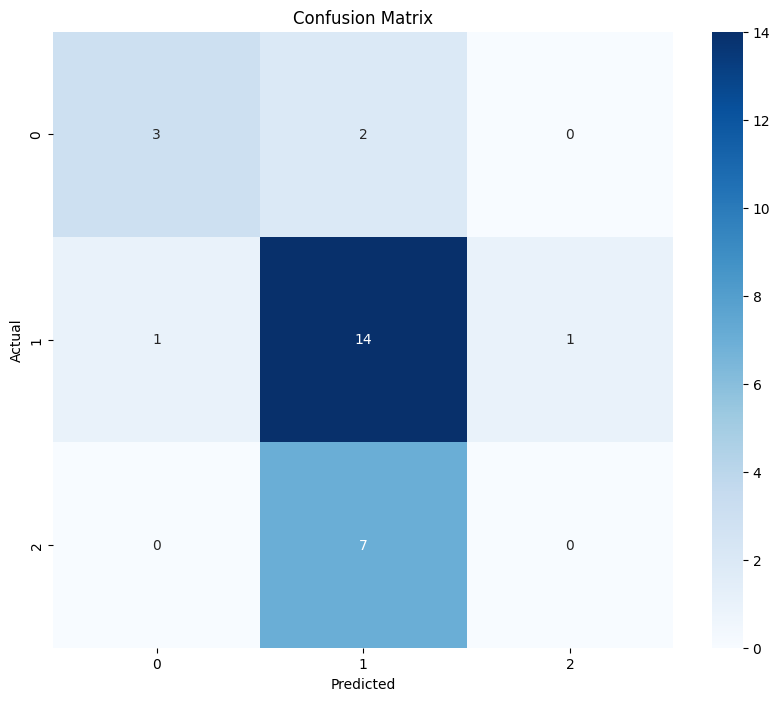

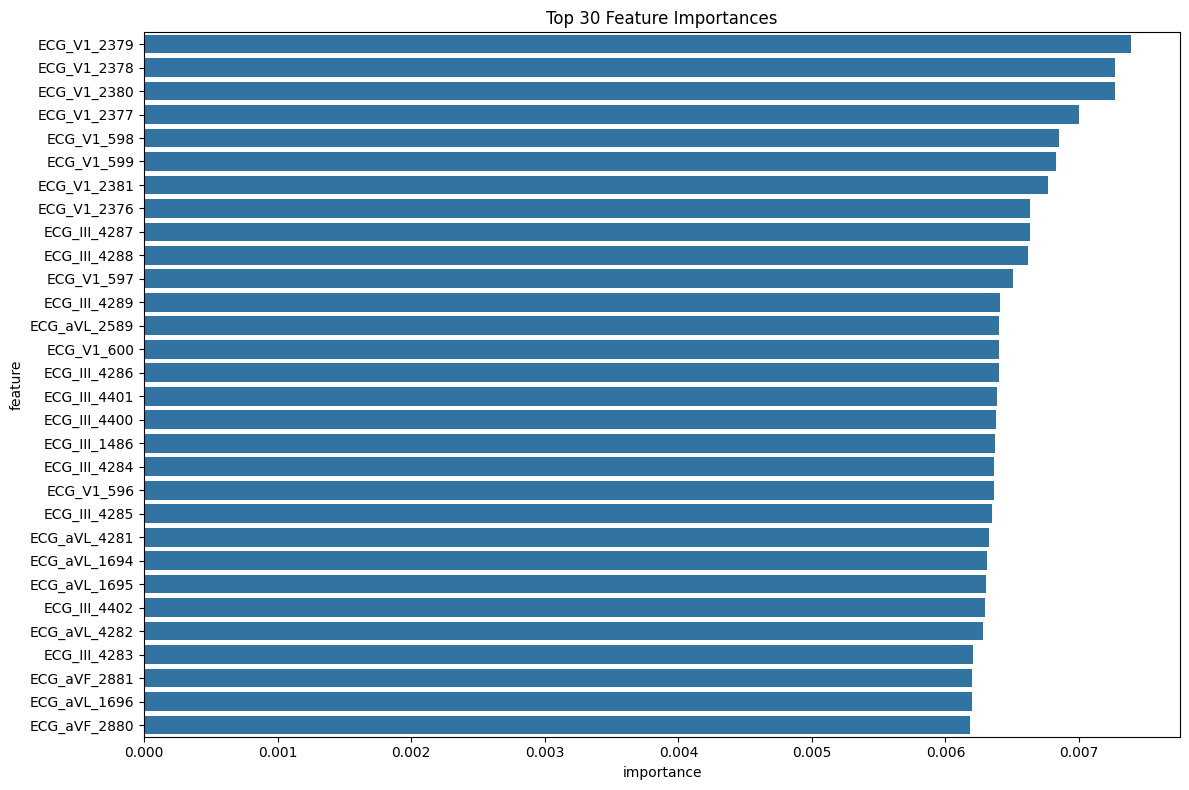

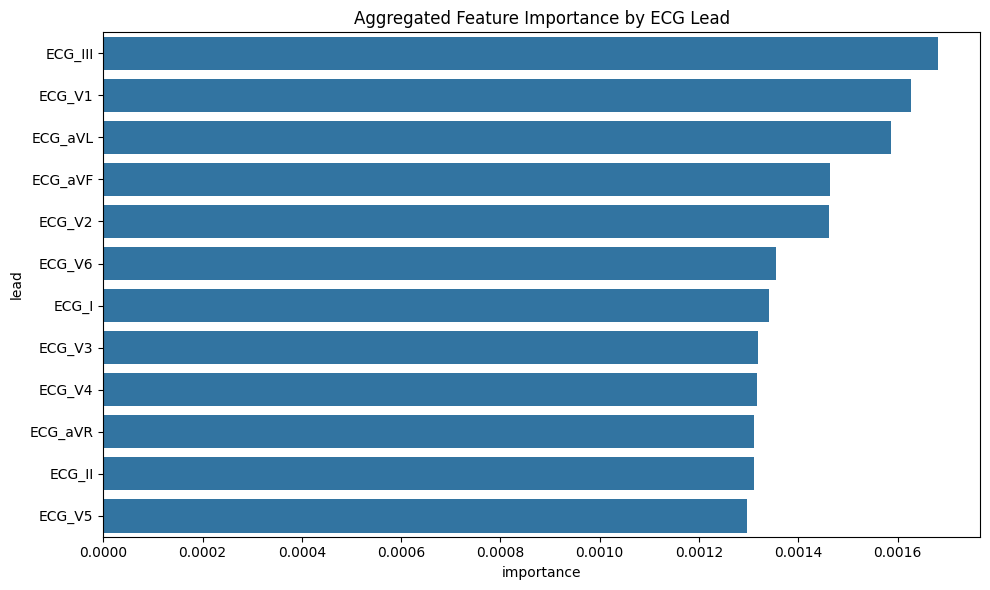

In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare the data
# Assuming cleaned_df is already loaded

# 2. Select features and target
ecg_columns = ['ECG_I', 'ECG_II', 'ECG_III', 'ECG_aVR', 'ECG_aVL', 'ECG_aVF', 'ECG_V1', 'ECG_V2', 'ECG_V3', 'ECG_V4', 'ECG_V5', 'ECG_V6']
X = cleaned_df[ecg_columns]
y = cleaned_df['Rhythm']

# 3. Preprocess the data
# Flatten the ECG readings and create new column names
X_flattened = pd.DataFrame()
new_column_names = []
for col in ecg_columns:
    flattened = X[col].apply(pd.Series)
    flattened.columns = [f"{col}_{i}" for i in range(len(flattened.columns))]
    X_flattened = pd.concat([X_flattened, flattened], axis=1)
    new_column_names.extend(flattened.columns)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# 5. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train the model
model = LogisticRegression(multi_class='ovr', max_iter=1000)
model.fit(X_train_scaled, y_train)

# 7. Make predictions
y_pred = model.predict(X_test_scaled)

# 8. Evaluate the model
print(classification_report(y_test, y_pred))

# 9. Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 10. Feature importance
# Get the first class coefficients (assuming binary classification)
coefficients = model.coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
feature_importance = pd.DataFrame({'feature': new_column_names, 'importance': np.abs(coefficients)})

# Sort by absolute importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 30 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(30))
plt.title('Top 30 Feature Importances')
plt.tight_layout()
plt.show()

# 11. Aggregate feature importance by ECG lead
lead_importance = pd.DataFrame({
    'lead': ecg_columns,
    'importance': [np.mean(np.abs(coefficients[i:i+len(coefficients)//len(ecg_columns)])) for i in range(0, len(coefficients), len(coefficients)//len(ecg_columns))]
})
lead_importance = lead_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='lead', data=lead_importance)
plt.title('Aggregated Feature Importance by ECG Lead')
plt.tight_layout()
plt.show()

/Users/rebeccaschuller/Desktop/AI4H/ai4h/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

        AFIB       0.75      0.60      0.67         5
          SB       0.61      0.88      0.72        16
          SR       0.00      0.00      0.00         7

    accuracy                           0.61        28
   macro avg       0.45      0.49      0.46        28
weighted avg       0.48      0.61      0.53        28



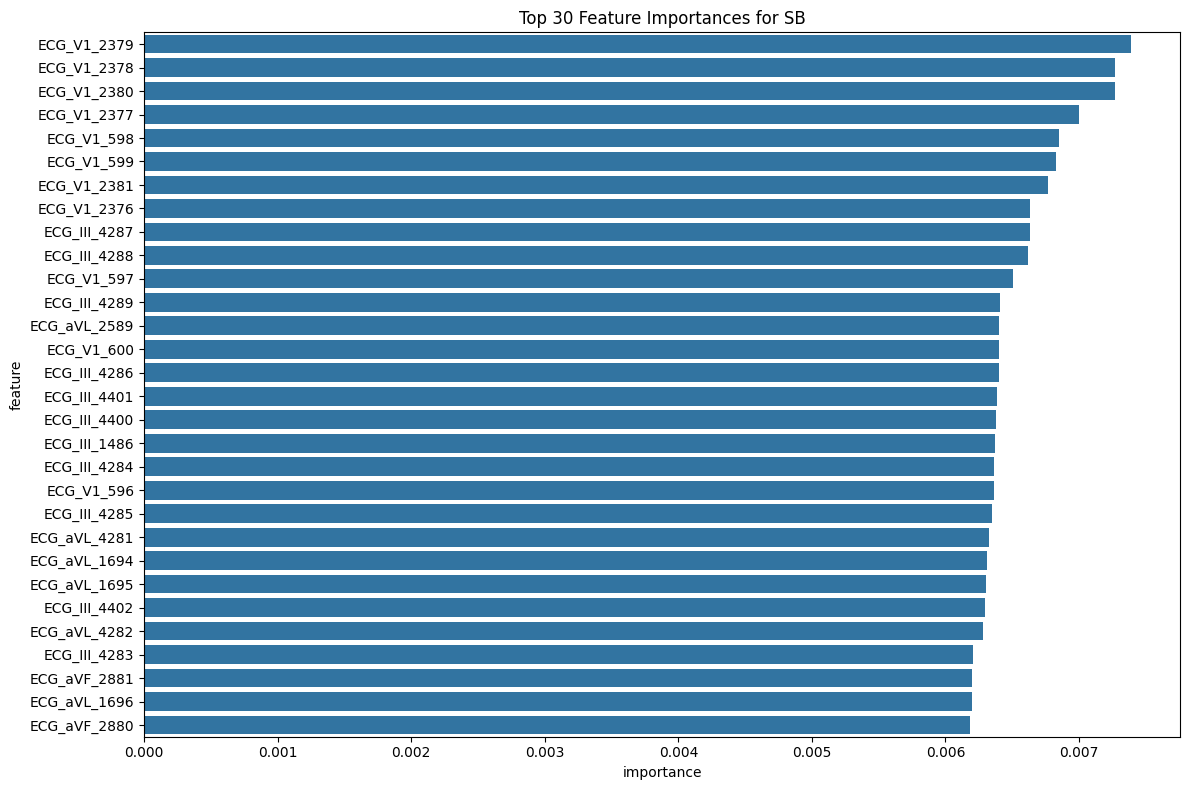

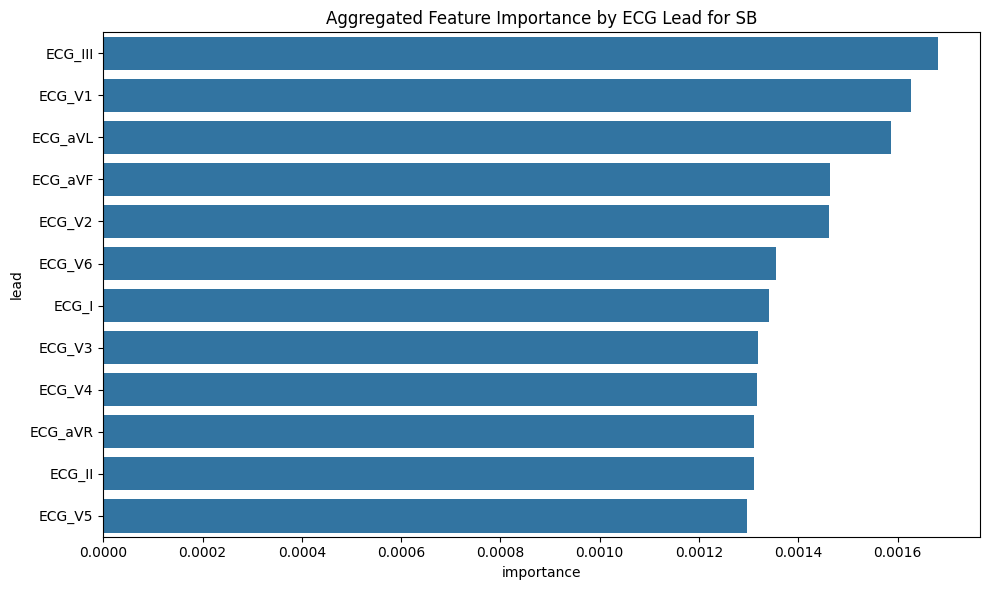

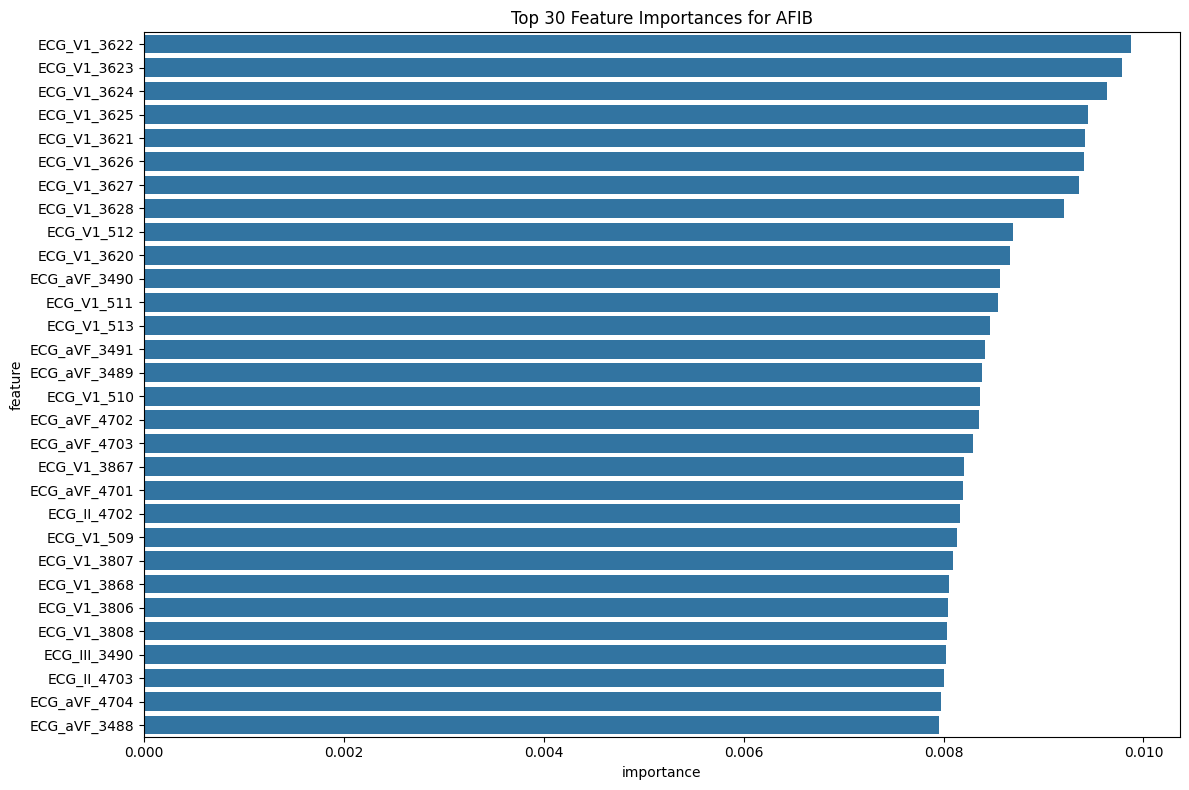

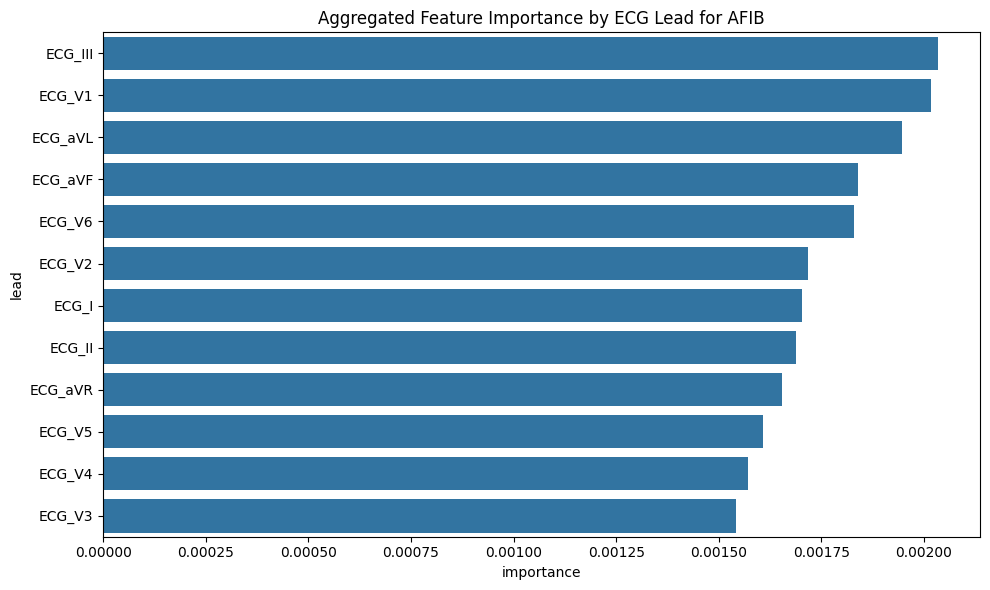

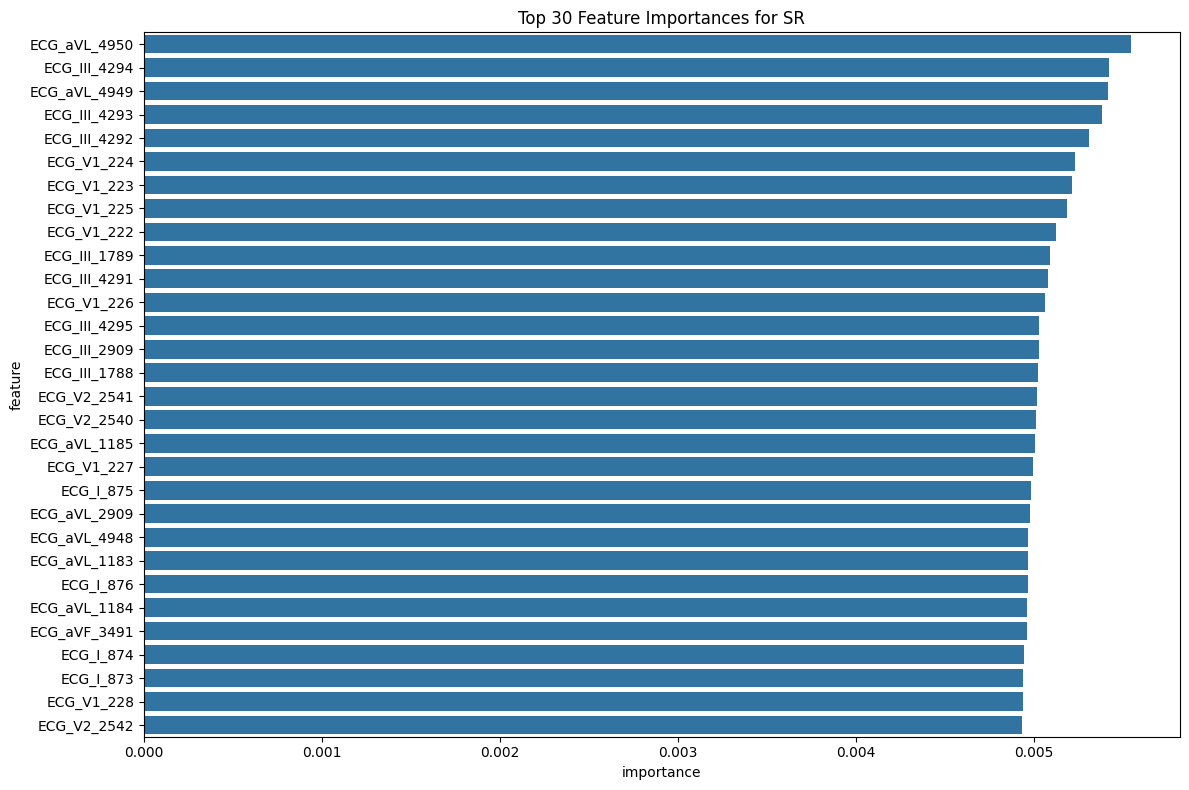

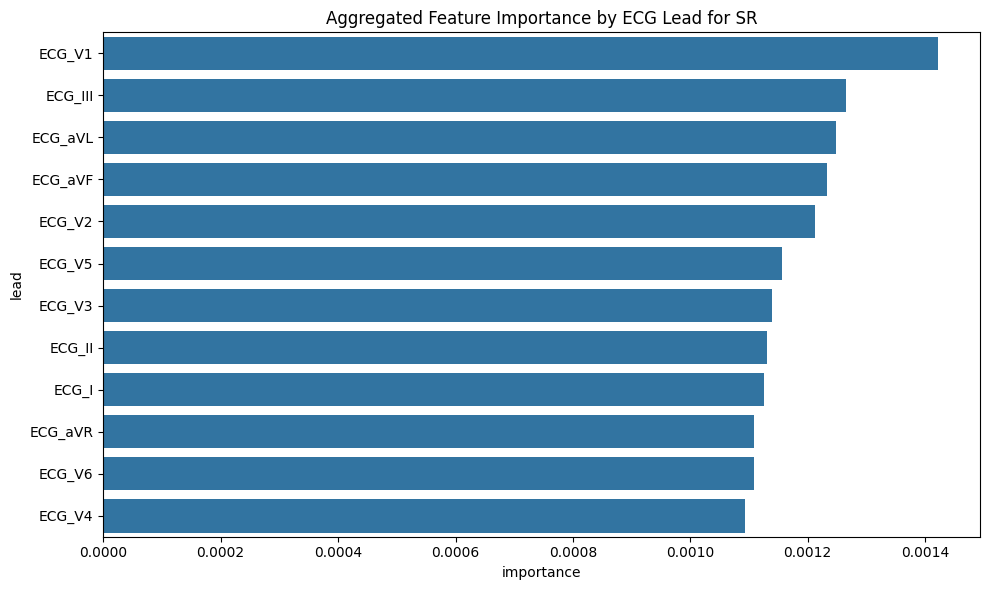

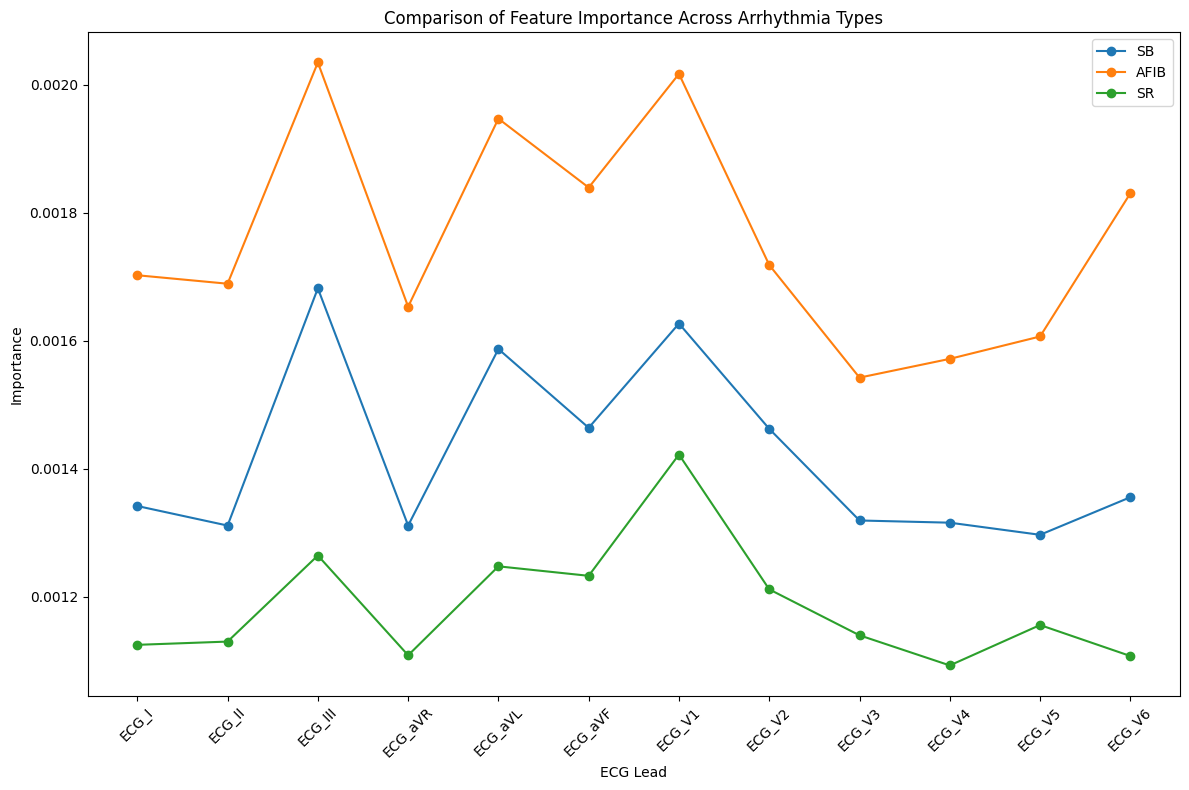

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum

class ArrhythmiaTypes(Enum):
    SB = "SB"
    AFIB = "AFIB"
    SR = "SR"

# 1. Load and prepare the data
# Assuming cleaned_df is already loaded

# 2. Select features and target
ecg_columns = ['ECG_I', 'ECG_II', 'ECG_III', 'ECG_aVR', 'ECG_aVL', 'ECG_aVF', 'ECG_V1', 'ECG_V2', 'ECG_V3', 'ECG_V4', 'ECG_V5', 'ECG_V6']
X = cleaned_df[ecg_columns]
y = cleaned_df['Rhythm']

# 3. Preprocess the data
X_flattened = pd.DataFrame()
new_column_names = []
for col in ecg_columns:
    flattened = X[col].apply(pd.Series)
    flattened.columns = [f"{col}_{i}" for i in range(len(flattened.columns))]
    X_flattened = pd.concat([X_flattened, flattened], axis=1)
    new_column_names.extend(flattened.columns)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# 5. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train the model
model = LogisticRegression(multi_class='ovr', max_iter=1000)
model.fit(X_train_scaled, y_train)

# 7. Make predictions
y_pred = model.predict(X_test_scaled)

# 8. Evaluate the model
print(classification_report(y_test, y_pred))

# 9. Feature importance for each arrhythmia type
def plot_feature_importance(coefficients, class_name):
    feature_importance = pd.DataFrame({'feature': new_column_names, 'importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(30))
    plt.title(f'Top 30 Feature Importances for {class_name}')
    plt.tight_layout()
    plt.show()
    
    # Aggregate feature importance by ECG lead
    lead_importance = pd.DataFrame({
        'lead': ecg_columns,
        'importance': [np.mean(np.abs(coefficients[i:i+len(coefficients)//len(ecg_columns)])) for i in range(0, len(coefficients), len(coefficients)//len(ecg_columns))]
    })
    lead_importance = lead_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='lead', data=lead_importance)
    plt.title(f'Aggregated Feature Importance by ECG Lead for {class_name}')
    plt.tight_layout()
    plt.show()

# Get the class indices
class_indices = {arrhythmia_type.value: i for i, arrhythmia_type in enumerate(ArrhythmiaTypes)}

# Plot feature importance for each arrhythmia type
for arrhythmia_type in ArrhythmiaTypes:
    class_index = class_indices[arrhythmia_type.value]
    if class_index < len(model.coef_):
        coefficients = model.coef_[class_index]
        plot_feature_importance(coefficients, arrhythmia_type.value)
    else:
        print(f"No coefficients found for {arrhythmia_type.value}")

# 10. Compare feature importances across arrhythmia types
plt.figure(figsize=(12, 8))
for arrhythmia_type in ArrhythmiaTypes:
    class_index = class_indices[arrhythmia_type.value]
    if class_index < len(model.coef_):
        coefficients = model.coef_[class_index]
        lead_importance = pd.DataFrame({
            'lead': ecg_columns,
            'importance': [np.mean(np.abs(coefficients[i:i+len(coefficients)//len(ecg_columns)])) for i in range(0, len(coefficients), len(coefficients)//len(ecg_columns))]
        })
        plt.plot(lead_importance['lead'], lead_importance['importance'], marker='o', label=arrhythmia_type.value)

plt.title('Comparison of Feature Importance Across Arrhythmia Types')
plt.xlabel('ECG Lead')
plt.ylabel('Importance')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()